# Predictive Modeling
## Wine Quality Dataset

We will do some analysis and transformation of the dataset, and try different classifier models to find out best accuracy scores.

In [23]:
# initialize environment for modeling and visualizing

%matplotlib inline
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pickle
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
import xgboost as xgb
from imblearn.over_sampling import SMOTE


from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

# initialize our cleaned red wine data input filename
# and an output filename for our model
inputfile = "static/data/clean_whitewineq.csv"
modelfile = "static/models/whitewine_model.sav"

In [40]:
#read data into pandas dataframe

wine_df = pd.read_csv(inputfile)
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulfates,alcohol,quality,quality_label
0,9.1,0.27,0.45,10.6,0.035,28.0,124.0,0.99700,3.20,0.46,10.4,9,excellent
1,6.6,0.36,0.29,1.6,0.021,24.0,85.0,0.98965,3.41,0.61,12.4,9,excellent
2,7.4,0.24,0.36,2.0,0.031,27.0,139.0,0.99055,3.28,0.48,12.5,9,excellent
3,6.9,0.36,0.34,4.2,0.018,57.0,119.0,0.98980,3.28,0.36,12.7,9,excellent
4,7.1,0.26,0.49,2.2,0.032,31.0,113.0,0.99030,3.37,0.42,12.9,9,excellent


In [25]:
# looking at the size of our dataset

print("Rows, columns: " + str(wine_df.shape))

Rows, columns: (4898, 13)


In [26]:
# looking at distribution across wine classes
# we can see that the majority falls in our middle class

wine_df.groupby("quality_label").count()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulfates,alcohol,quality
quality_label,,,,,,,,,,,,
excellent,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060
good,3818,3818,3818,3818,3818,3818,3818,3818,3818,3818,3818,3818
poor,20,20,20,20,20,20,20,20,20,20,20,20



*** We divided our data into 3 quality buckets; poor, good, and excellent.  Quality scores 3 and under were placed in the poor bucket. Quality scores greater than 3 and less than 7 were placed in the good bucket.  Scores 7 and over were placed in the excellent bucket. ***

We tested models using a binary classification system (good/poor), but our accuracy scores were higher using 3 classes.


In [27]:
# looking for null values (data preprocessed to eliminate null values)
print(wine_df.isna().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulfates                0
alcohol                 0
quality                 0
quality_label           0
dtype: int64


In [28]:
# let's see how the data is distributed across numeric quality values
# the plot lets us visualize the fact that our data is normally distributed, and so, not
# balanced

fig = px.histogram(wine_df,x='quality', marginal="box", color_discrete_sequence=["#d65a51"])
fig.show()

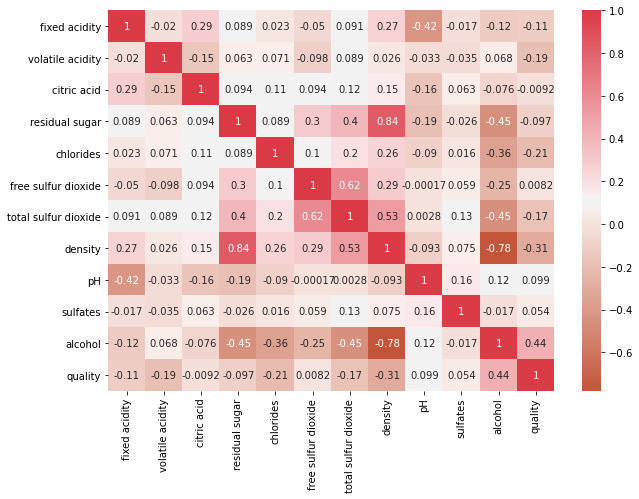

In [29]:
# let's build a correlation matrix to look for any strong correlations
# between features
# we can see a relationship between some of the features, but
# very few strong correlations to quality

corr = wine_df.corr()
plt.subplots(figsize=(10,7))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(20, 10, as_cmap=True))
plt.show()

In [30]:
# let's look for any outliers -- need to drop labels
plot_df = wine_df.drop(['quality_label'], axis = 1)

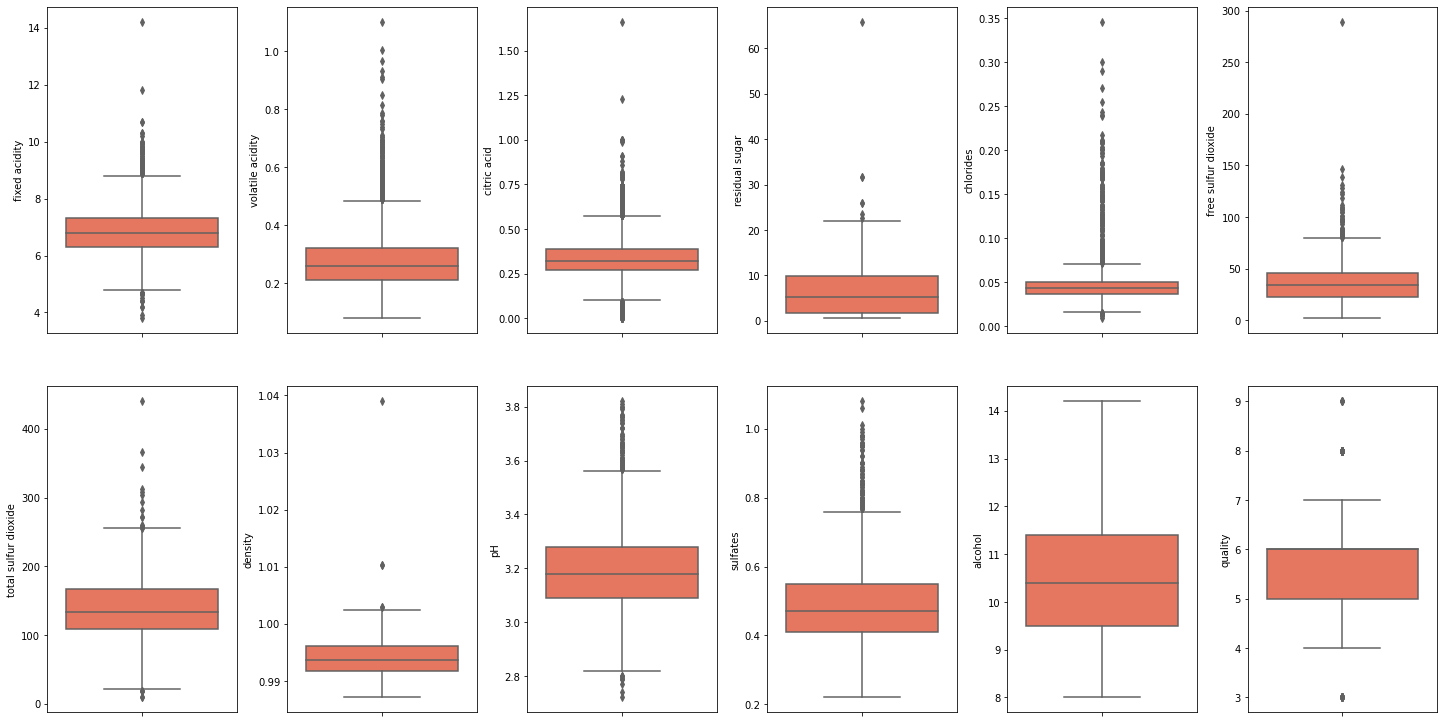

In [31]:
# data does have a few outliers skewing our data
# we can remove them, or normalize them, but it is not
# likely that this will greatly improve our results

fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(20,10))
index = 0
ax = ax.flatten()
for col, value in plot_df.items():
    sns.boxplot(y=col, data=plot_df, ax=ax[index], palette='Reds')
    index += 1
    
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

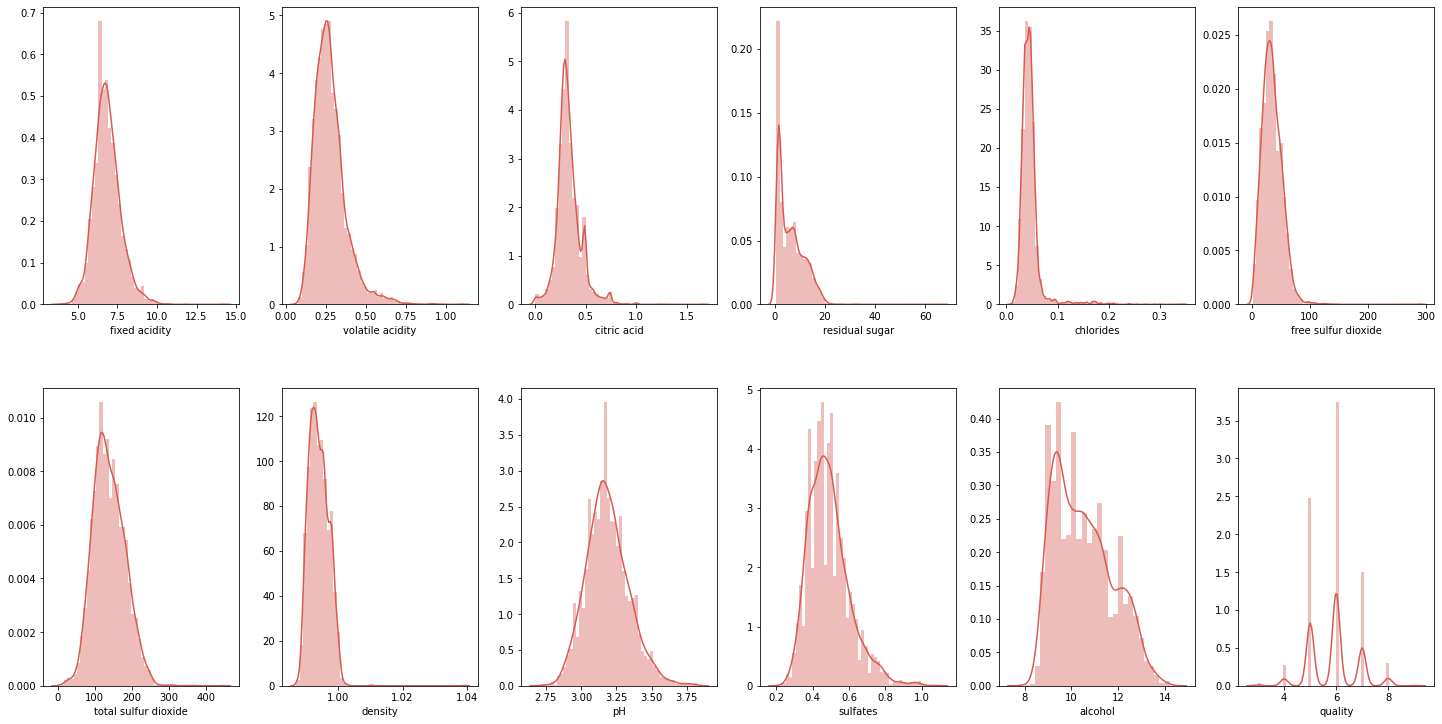

In [32]:
# looking at the distribution of each feature, they all seem to
# be normally distributed, albeit, some are skewed, probably due
# to our outliers

fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(20,10))
index = 0
ax = ax.flatten()
for col, value in plot_df.items():
    sns.distplot(value, ax=ax[index], color="#d65a51")
    index += 1
    
plt.tight_layout(pad=0.5, w_pad=0.7, h_pad=5.0)

In [33]:
# let's look at how our min/max/mean values relate to one another
# if we want to take action on our outliers, this will be helpful

wine_df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulfates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.856121,0.278340,0.334244,6.392862,0.045783,35.308085,138.360657,0.994027,3.188246,0.489851,10.514267,5.877909
std,0.843244,0.100766,0.120961,5.071275,0.021846,17.007137,42.498065,0.002991,0.150910,0.114127,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [34]:
# pull our X and y data for modeling
# quality label ("excellent/good/poor") will be our class

X = wine_df.drop(['quality', 'quality_label'], axis = 1)
y = wine_df['quality_label']

In [35]:
# use StandardScalar() to normalize our data

#X_features = X
#X = StandardScaler().fit_transform(X)

In [36]:
# because our dataset is so far out of balance, with so few datapoints
# in our poor and excellent categories, we decided to run SMOTE() to
# balance our dataset

oversample = SMOTE()
X, y = oversample.fit_resample(X,y)

In [37]:
# split data into training and testing data, with a 75%-25% split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=0)

In [38]:
# function to run each classification model we have chosen,
# report the accuracy score, and plot the confusion matrix

def run_models(X_train, X_test, y_train, y_test):
    models = [DecisionTreeClassifier(random_state=1), RandomForestClassifier(n_estimators=100), SVC(), SVC(kernel='linear'), AdaBoostClassifier(random_state=1), GradientBoostingClassifier(random_state=1), xgb.XGBClassifier(eval_metric='mlogloss'), SGDClassifier(penalty=None)]
    for model_type in models:
        model = model_type     
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        
        model_str = str(model_type)
        model_name = model_str.split("(")
        
        print(f"Model: {model_name[0]}\nAccuracy Score: {round(accuracy_score(y_test, pred)*100)}\n")
        
        cm = confusion_matrix(y_test, pred)
        
        print("Confusion Matrix")
        plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Reds)
        plt.show()
        print("\n\n")
          

Model: DecisionTreeClassifier
Accuracy Score: 88.0

Confusion Matrix


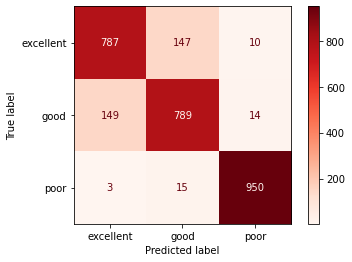




Model: RandomForestClassifier
Accuracy Score: 94.0

Confusion Matrix


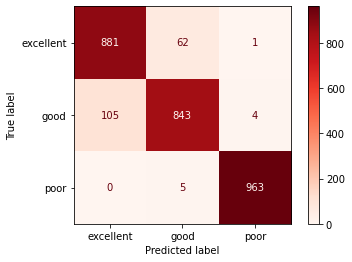




Model: SVC
Accuracy Score: 60.0

Confusion Matrix


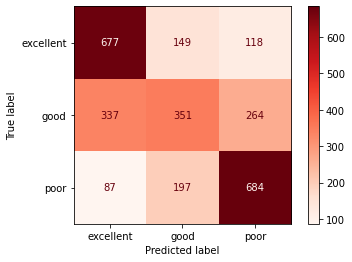




Model: SVC
Accuracy Score: 64.0

Confusion Matrix


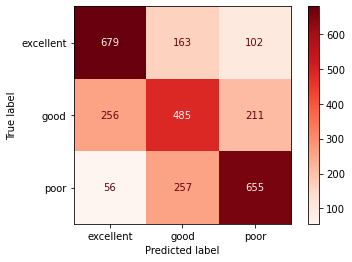




Model: AdaBoostClassifier
Accuracy Score: 71.0

Confusion Matrix


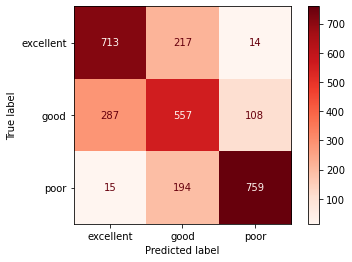




Model: GradientBoostingClassifier
Accuracy Score: 87.0

Confusion Matrix


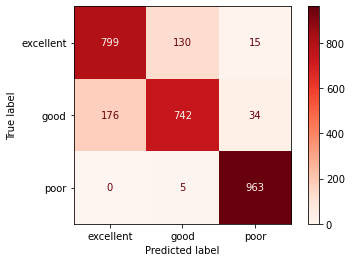




Model: XGBClassifier
Accuracy Score: 94.0

Confusion Matrix


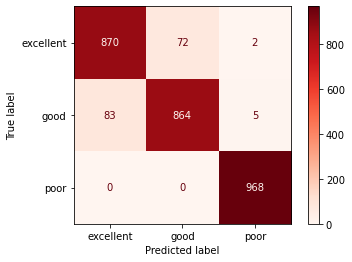




Model: SGDClassifier
Accuracy Score: 55.0

Confusion Matrix


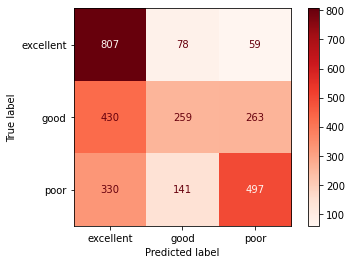

In [39]:
# call our function to run each of our chosen modes

run_models(X_train, X_test, y_train, y_test)

# Results
We had excellent results with many of our models, but Random Forests were a standout at 96% accuracy.  We will save that model for predicting the quality of new data values.

Model: RandomForestClassifier
Accuracy Score: 94.0

Confusion Matrix


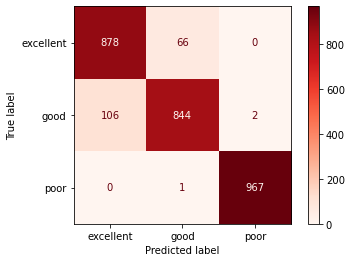

In [41]:
model = RandomForestClassifier(n_estimators=100)     
model.fit(X_train, y_train)
pred = model.predict(X_test)
        
        
print(f"Model: RandomForestClassifier\nAccuracy Score: {round(accuracy_score(y_test, pred)*100)}\n")
        
cm = confusion_matrix(y_test, pred)
        
print("Confusion Matrix")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Reds)
plt.show()
print("\n\n")

In [42]:
# Save the model

pickle.dump(model, open(modelfile, 'wb'))

In [43]:
# create a valid list of potential user-entered test data

user_test = [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]

In [44]:
# load the model in and see how the user did

loaded_model = pickle.load(open(modelfile, 'rb'))
print(f"Predicted class: {loaded_model.predict(user_test)}")

Predicted class: ['good']


# Sources

Understanding Random Forest
How the Algorithm Works and Why it Is So Effective
Tony Yiu  Jun 12, 2019
https://towardsdatascience.com/understanding-random-forest-58381e0602d2


Wine Quality Prediction Analysis | Machine Learning | Python
Hackers Realm  Oct 21, 2020
https://www.youtube.com/watch?v=W25TEa93T_I


Predicting Wine Quality with Several Classification Techniques
A data science project walkthrough with code!
Terence Shin  May 7, 2020
https://towardsdatascience.com/predicting-wine-quality-with-several-classification-techniques-179038ea6434